**Mounting Drive to Virtual Machine.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing required Libraries.**

In [ ]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
    Dropout,
    Input, 
    Concatenate,
    GlobalAveragePooling2D, 
    GlobalMaxPooling2D,
)
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip3 install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=ec6629a923bf0c83b2ffe98b82d501e6a9e001051f6b5c01f31a533e067189cd
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


**After mounting drive and importing packages
 directly run the below cell to avoid runtime loss of virtual machine.**
 



In [ ]:
import pickle

pickle_in = open("/content/drive/Shareddrives/Project2022/COVID-19/pickle_files/positive1_npy.pickle","rb")
positive_npy=pickle.load(pickle_in)
pickle_in = open("/content/drive/Shareddrives/Project2022/COVID-19/pickle_files/negative1_npy.pickle","rb")
negative_npy=pickle.load(pickle_in)

In [ ]:
print(positive_npy.shape)
print(negative_npy.shape)

(7593, 64, 64, 3)
(6893, 64, 64, 3)


In [ ]:
# To load dataset and concat them to x and y
def load_data():
    positive = positive_npy
    positive_labels = ["1" for i in positive]
    negative = negative_npy
    negative_labels = ["0" for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative])
    Y = np.array((positive_labels + negative_labels), dtype=np.float32)
    return X, Y

**DenseNet121.**




In [ ]:
# DenseNet-121 model
def densenet121(): 
    from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate ,Dropout
    from tensorflow.keras.models import Model
    densenet = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False)
    
    input = Input(shape=(64, 64, 3))
    x = densenet(input)
    
    x = GlobalAveragePooling2D()(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(3, activation="softmax", name='root')(x)
 

    # model
    model = Model(input,output)
    model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    
    return model

In [ ]:
X, Y = load_data()
print(X.shape)
print(Y.shape)

(14486, 64, 64, 3)
(14486,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
model = densenet121()
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0      

In [ ]:
model = densenet121()
model.summary()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

datagen = ImageDataGenerator(rotation_range=180, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically
BATCH_SIZE = 64
datagen.fit(X_train)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                           

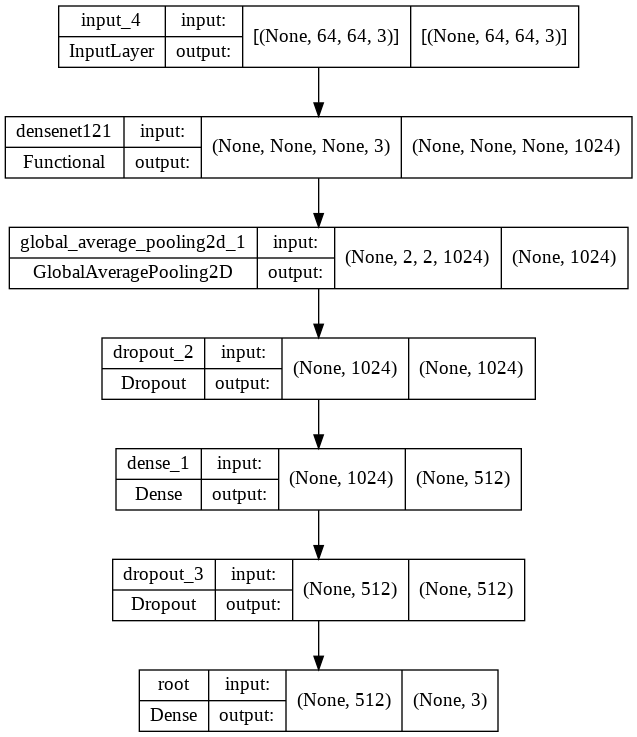

In [ ]:
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical, Sequence
from IPython.display import Image
from IPython.display import SVG
plot_model(model, to_file='dense121.png', show_shapes=True,show_layer_names=True)
Image(filename='dense121.png') 

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE, #31
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val))


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


181/181 [==============================] - 69s 285ms/step - loss: 0.7018 - accuracy: 0.7514 - val_loss: 1.4619 - val_accuracy: 0.5305
Epoch 2/50
181/181 [==============================] - 47s 258ms/step - loss: 0.4884 - accuracy: 0.7995 - val_loss: 0.7003 - val_accuracy: 0.7876
Epoch 3/50
181/181 [==============================] - 57s 313ms/step - loss: 0.4194 - accuracy: 0.8179 - val_loss: 0.3590 - val_accuracy: 0.8367
Epoch 4/50
181/181 [==============================] - 57s 312ms/step - loss: 0.3697 - accuracy: 0.8439 - val_loss: 0.7116 - val_accuracy: 0.6224
Epoch 5/50
181/181 [==============================] - 56s 312ms/step - loss: 0.3406 - accuracy: 0.8571 - val_loss: 0.3212 - val_accuracy: 0.8805
Epoch 6/50
181/181 [==============================] - 61s 336ms/step - loss: 0.3186 - accuracy: 0.8720 - val_loss: 0.4138 - val_accuracy: 0.8395
Epoch 7/50
181/181 [==============================] - 47s 257ms/step - loss: 0.3070 - accuracy: 0.8749 - val_loss: 0.2566 - val_accuracy: 0.8

In [ ]:
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred, axis=-1)
accuracy = np.equal(Y_test, predicted).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9092320966350302


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test, predicted))


              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90      2772
         1.0       0.89      0.94      0.92      3023

    accuracy                           0.91      5795
   macro avg       0.91      0.91      0.91      5795
weighted avg       0.91      0.91      0.91      5795



**Confusion Matrix.**

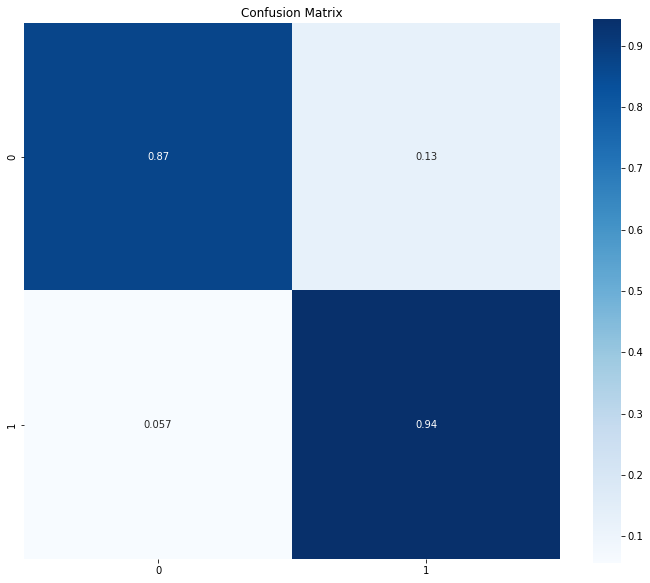

In [ ]:
cm = confusion_matrix(Y_test, predicted, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

**Accuracy vs Loss vs Epochs plots.**

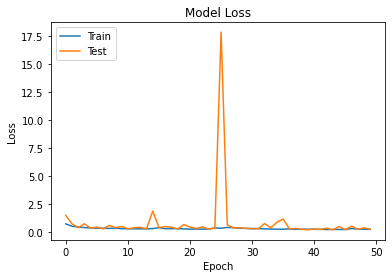

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

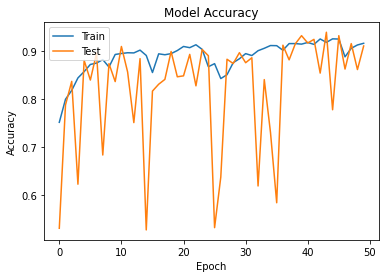

In [ ]:
# To plot learning curves
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Saving the Model

In [ ]:
model.save("/content/drive/Shareddrives/Project2022/COVID-19/Weights/DenseNet.h5")
model.save_weights("/content/drive/Shareddrives/Project2022/COVID-19/Weights/DenseNet_weights.h5")

**Final Prediction and Report**

In [ ]:
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred,axis=-1)[:50]
l12 = np.array(Y_test)[:50]
l12=l12.astype(int)

In [ ]:
print(predicted)
print(l12)

[0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 0 0 0 0]
[0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 0 0 0 0]


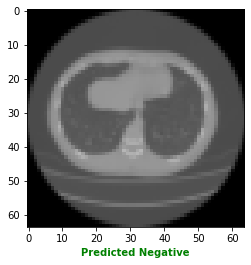

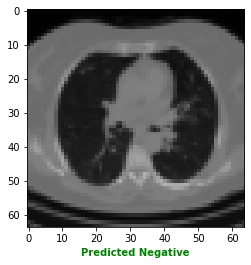

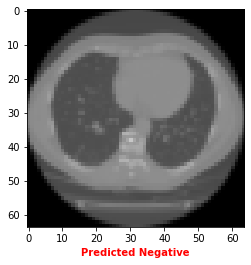

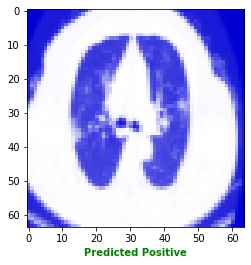

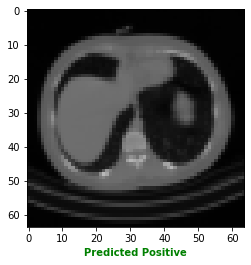

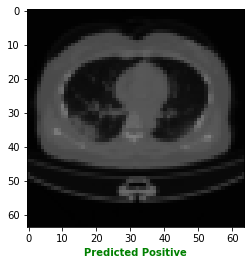

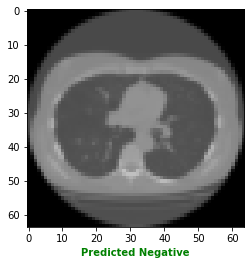

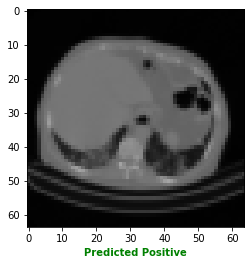

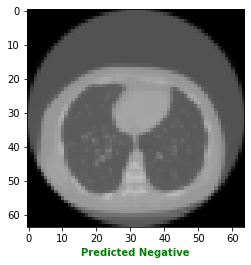

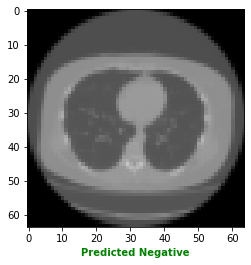

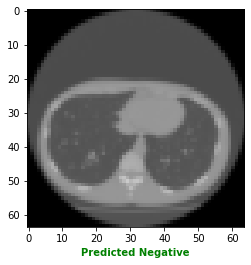

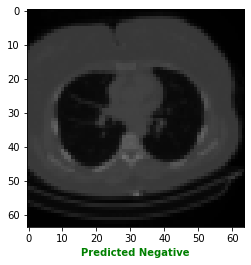

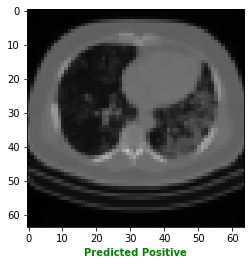

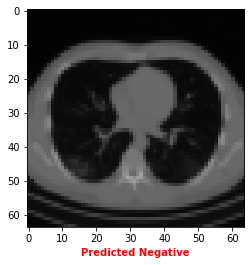

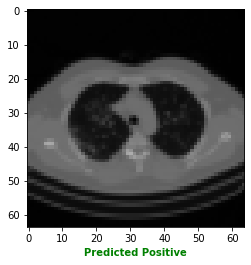

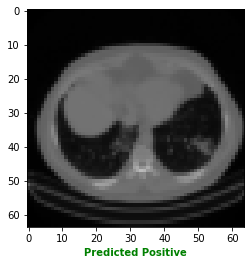

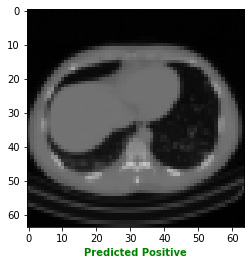

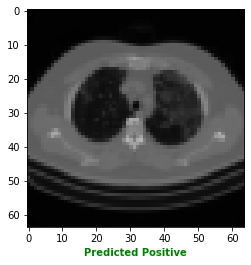

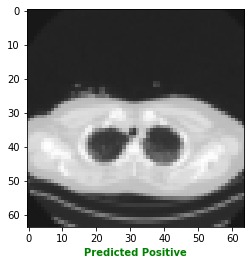

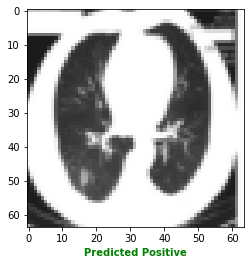

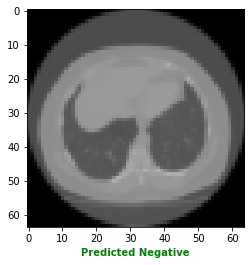

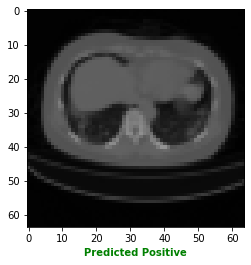

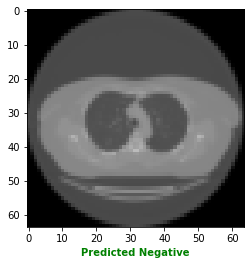

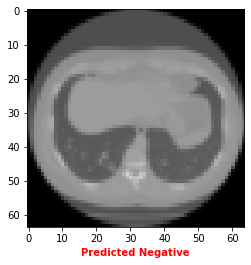

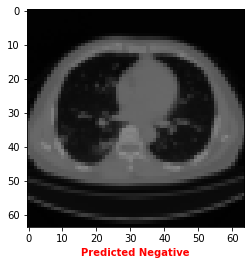

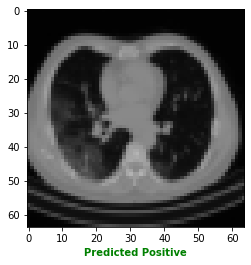

In [ ]:
# To print the final report
j = 0
k = 0

for i in range(0,26): 
  # Report for positive predicted cases
  if (np.argmax(y_pred[i]) == l12[i]):
    if(np.argmax(y_pred[i]) == 1):
      plt.imshow(X_test[i].squeeze(), cmap="gray")
      plt.xlabel(
        "Predicted Positive",        
        fontweight="bold",color="green"
        )
      plt.show()
      j = j + 1
    else:
      plt.imshow(X_test[i].squeeze(), cmap="gray")
      plt.xlabel(
        "Predicted Negative",        
        fontweight="bold",color="green"
        )
      plt.show()
      j = j + 1
  else: 
    if(np.argmax(y_pred[i]) == 1):
      plt.imshow(X_test[i].squeeze(), cmap="gray")
      plt.xlabel(
        "Predicted Positive",        
        fontweight="bold",color="red"
        )
      plt.show()
      j = j + 1
    else:
      plt.imshow(X_test[i].squeeze(), cmap="gray")
      plt.xlabel(
        "Predicted Negative",        
        fontweight="bold",color="red"
        )
      plt.show()
      j = j + 1
